In [1]:
from numpy.random import RandomState
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk import word_tokenize
import spacy as spacy
from time import time
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import string
import re

from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers.core import Reshape, Flatten
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import model_from_json
from keras.optimizers import Adam, SGD
from keras.utils import to_categorical
from keras.layers import Embedding    
from keras.models import Model
from keras.models import Model
from keras import regularizers

from gensim.models.keyedvectors import KeyedVectors
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
import gensim

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skmultilearn.problem_transform import LabelPowerset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import class_weight
import tensorflow.keras.backend as K
from sklearn.utils import resample

Using TensorFlow backend.


In [2]:
class BaseClassifier(object):
    
    def __init__(self):
        self.df = pd.read_csv("../../datasets/BaseClassifierDataset.csv") 
        self.df.columns = [c.replace(' ', '') for c in self.df.columns]
        self.df.columns = [c.replace(',', '') for c in self.df.columns]
        self.df.columns = [c.replace('/', '') for c in self.df.columns]
                         
        self.NUM_WORDS = 5000
        self.EMBEDDING_DIM = 300
        self.tokenizer = Tokenizer(num_words=self.NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', lower=True)
        
    def clean_text(self):
        self.df['Text_Clean'] = self.df['Clause'].apply(lambda x: self.remove_punct(x))
        tokens = [word_tokenize(sen) for sen in self.df.Text_Clean]
        lower_tokens = [self.lower_token(token) for token in tokens]
        filtered_words = [self.removeStopWords(sen) for sen in lower_tokens]
        self.df['Text_Final'] = [' '.join(sen) for sen in filtered_words]
        self.df['tokens'] = filtered_words  
        self.preprocess_text()
        
        self.df.Clause = self.df.Text_Final
        self.df = self.df[['Id', 'Clause', 'DataRetention', 'DataSecurity', 'DoNotTrack',
                           'FirstPartyCollectionUse', 'InternationalandSpecificAudiences', 'Other',
                           'PolicyChange', 'ThirdPartySharingCollection',
                           'UserAccessEditandDeletion', 'UserChoiceControl']]
        
    def upsample_and_split(self):
        dr_class0 = self.df[self.df.DataRetention == 0]
        dr_class1 = self.df[self.df.DataRetention == 1]
        dr_class1_upsampled = resample(dr_class1, n_samples=1000, replace=True, random_state=43)
        self.df = pd.concat([dr_class0, dr_class1_upsampled])
        
        ds_class0 = self.df[self.df.DataSecurity == 0]
        ds_class1 = self.df[self.df.DataSecurity == 1]   
        ds_class1_upsampled = resample(ds_class1, n_samples=1000, replace=True, random_state=43)
        self.df = pd.concat([ds_class0, ds_class1_upsampled])
        
        dnt_class0 = self.df[self.df.DoNotTrack == 0]
        dnt_class1 = self.df[self.df.DoNotTrack == 1]   
        dnt_class1_upsampled = resample(dnt_class1, n_samples=1000, replace=True, random_state=43)
        self.df = pd.concat([dnt_class0, dnt_class1_upsampled])
        
        isa_class0 = self.df[self.df.InternationalandSpecificAudiences == 0]
        isa_class1 = self.df[self.df.InternationalandSpecificAudiences == 1]   
        isa_class1_upsampled = resample(isa_class1, n_samples=1000, replace=True, random_state=43)
        self.df = pd.concat([isa_class0, isa_class1_upsampled])
        
        pc_class0 = self.df[self.df.PolicyChange == 0]
        pc_class1 = self.df[self.df.PolicyChange == 1]   
        pc_class1_upsampled = resample(pc_class1, n_samples=1000, replace=True, random_state=43)
        self.df = pd.concat([pc_class0, pc_class1_upsampled])
        
        uced_class0 = self.df[self.df.UserAccessEditandDeletion == 0]
        uced_class1 = self.df[self.df.UserAccessEditandDeletion == 1]   
        uced_class1_upsampled = resample(uced_class1, n_samples=1000, replace=True, random_state=43)
        self.df = pd.concat([uced_class0, uced_class1_upsampled])       
        
        ucc_class0 = self.df[self.df.UserChoiceControl == 0]
        ucc_class1 = self.df[self.df.UserChoiceControl == 1]   
        ucc_class1_upsampled = resample(ucc_class1, n_samples=1000, replace=True, random_state=43)
        self.df = pd.concat([ucc_class0, ucc_class1_upsampled])       
        
        categories = self.df[['DataRetention', 'DataSecurity', 'DoNotTrack',
                           'FirstPartyCollectionUse', 'InternationalandSpecificAudiences', 'Other',
                           'PolicyChange', 'ThirdPartySharingCollection',
                           'UserAccessEditandDeletion', 'UserChoiceControl']]         
        
        X = self.df.Clause
        y = categories.values
                
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=RandomState())
        
    def preprocess_text(self):
        nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
        brief_cleaning = (re.sub("[^A-Za-z]+", ' ', str(row)).lower() for row in self.df['Clause'])
        t = time()
        txt = [self.cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]
        print('Time taken to cleanup everything: {} mins'.format(round((time() - t)/60, 2)))
    
    def cleaning(self, doc):
        txt = [token.lemma_ for token in doc if not token.is_stop]
        if len(txt) > 2:
            return ' '.join(txt)

    def remove_punct(self, text):
        text_nopunct = ''
        text_nopunct = re.sub('['+string.punctuation+']', '', text)
        text_nopunct = re.sub(r'\s+', ' ', text_nopunct)
        return text_nopunct
    
    def lower_token(self, tokens): 
        return [w.lower() for w in tokens]   
    
    def removeStopWords(self, tokens): 
        stoplist = stopwords.words('english')
        return [word for word in tokens if word not in stoplist]
    
    def text_to_sequence(self):
        self.tokenizer.fit_on_texts(self.df.Clause)
        sequences_train = self.tokenizer.texts_to_sequences(self.X_train) 
        sequences_test = self.tokenizer.texts_to_sequences(self.X_test)

        vocab_size = len(self.tokenizer.word_index) + 1
        self.maxlen = max([len(s.split()) for s in self.df.Clause])
        
        self.X_train = pad_sequences(sequences_train, padding='post', maxlen=self.maxlen)               
        self.X_test = pad_sequences(sequences_test, padding='post', maxlen=self.maxlen)
                        
        print('Shape of X train tensor:', self.X_train.shape)
        print('Shape of X test tensor:', self.X_test.shape)
        
        return vocab_size

    def word_to_vec(self, vocab_size):
        word_vectors = KeyedVectors.load_word2vec_format('../../models/w2v_base_model.bin', binary=True)

        embedding_matrix = np.zeros((vocab_size, self.EMBEDDING_DIM))

        for word, i in self.tokenizer.word_index.items():
            if i >= self.NUM_WORDS:
                continue
            try:
                embedding_vector = word_vectors[word]
                embedding_matrix[i] = embedding_vector
            except KeyError:
                embedding_matrix[i] = np.random.normal(0,np.sqrt(0.25), self.EMBEDDING_DIM)

        del(word_vectors)

        embedding_layer = Embedding(vocab_size, self.EMBEDDING_DIM, weights=[embedding_matrix], trainable=True)
        return embedding_layer

    def build_model(self, embedding_layer):
        filter_sizes = [3, 3, 3, 3]
        num_filters = 256

        inputs = Input(shape=(self.maxlen,))
        embedding = embedding_layer(inputs)
        reshape = Reshape((self.maxlen, self.EMBEDDING_DIM, 1))(embedding)

        conv_0 = Conv2D(num_filters, (filter_sizes[0], self.EMBEDDING_DIM),activation='relu', kernel_regularizer=regularizers.l2(0.003))(reshape)
        conv_1 = Conv2D(num_filters, (filter_sizes[1], self.EMBEDDING_DIM),activation='relu', kernel_regularizer=regularizers.l2(0.003))(reshape)
        conv_2 = Conv2D(num_filters, (filter_sizes[2], self.EMBEDDING_DIM),activation='relu', kernel_regularizer=regularizers.l2(0.003))(reshape)
        conv_3 = Conv2D(num_filters, (filter_sizes[3], self.EMBEDDING_DIM),activation='relu', kernel_regularizer=regularizers.l2(0.003))(reshape)

        maxpool_0 = MaxPooling2D((self.maxlen - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
        maxpool_1 = MaxPooling2D((self.maxlen - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
        maxpool_2 = MaxPooling2D((self.maxlen - filter_sizes[2] + 1, 1), strides=(1,1))(conv_2)
        maxpool_3 = MaxPooling2D((self.maxlen - filter_sizes[3] + 1, 1), strides=(1,1))(conv_3)

        merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2, maxpool_3], axis=1)
        flatten = Flatten()(merged_tensor)
        reshape = Reshape((4*num_filters,))(flatten)
        output = Dense(units=10, activation='sigmoid', kernel_regularizer=regularizers.l2(0.003))(reshape)
        return inputs, output

    def train_model(self, inputs, output):
        model = Model(inputs, output)
        adam = Adam(lr=1e-3)
        model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc'])
        callback_checkpoint = ModelCheckpoint("base_classifier_weights.h5", monitor='val_loss', verbose=1, save_best_only=True)
        callbacks = [
            EarlyStopping(patience=5, monitor='val_loss'),
            callback_checkpoint
        ]
        history = model.fit(self.X_train, self.y_train, batch_size=16, epochs=30, verbose=1, validation_split=0.3, 
                             callbacks=callbacks) 
        return history, model
    
    def evaluate_model(self, history, model):
        loss, acc = model.evaluate(self.X_test, self.y_test, verbose = 1)
        print("Test Accuracy: %f" % (acc*100))
        
        y_pred = model.predict(self.X_test)
        y_pred[y_pred>=0.5] = 1
        y_pred[y_pred<0.5] = 0
            
        target_names = ['DataRetention', 'DataSecurity', 'DoNotTrack',
                       'FirstPartyCollectionUse', 'InternationalandSpecificAudiences', 'Other',
                       'PolicyChange', 'ThirdPartySharingCollection',
                       'UserAccessEditandDeletion', 'UserChoiceControl']
        
        print(classification_report(self.y_test, y_pred, target_names = target_names, zero_division='warn'))
        
        cnf_matrix = confusion_matrix(self.y_test.argmax(axis=1), y_pred.argmax(axis=1), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
        np.set_printoptions(precision=2)
        plt.figure(figsize=(20,10))
        self.plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix, without normalization')

        plt.figure(figsize=(20,10))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train','test'], loc='upper left')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train','test'], loc='upper left')
        plt.show()
                
    def plot_confusion_matrix(self, cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        
    def predict(self, model):
        model.load_weights("base_classifier_weights.h5")
        predictions = model.predict(np.expand_dims(self.X_test[50], 0))
        print(self.tokenizer.sequences_to_texts([self.X_test[50]]))
        print(self.y_test[50])
        print(predictions)
   
    def getmaxlen(self): 
        return self.maxlen

In [3]:
def main():
    np.set_printoptions(threshold=np.inf)
    base_classifier = BaseClassifier()
    base_classifier.clean_text()
    base_classifier.upsample_and_split()
    vocab_size = base_classifier.text_to_sequence()
    embedding_layer = base_classifier.word_to_vec(vocab_size)
    inputs, output = base_classifier.build_model(embedding_layer)
    history, model = base_classifier.train_model(inputs, output)
    print(model.summary())
    base_classifier.evaluate_model(history, model)
    base_classifier.predict(model)
    with open('../../models/BaseClassifier.json', "w") as json_file:
        json_file.write(model.to_json())

Time taken to cleanup everything: 0.37 mins
Shape of X train tensor: (5849, 214)
Shape of X test tensor: (1463, 214)


D:\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4094 samples, validate on 1755 samples
Epoch 1/30
4094/4094 [==============================] - 80s 20ms/step - loss: 0.4414 - acc: 0.8905 - val_loss: 0.3899 - val_acc: 0.9140

Epoch 00001: val_loss improved from inf to 0.38991, saving model to base_classifier_weights.h5
Epoch 2/30
4094/4094 [==============================] - 80s 19ms/step - loss: 0.3654 - acc: 0.9232 - val_loss: 0.3565 - val_acc: 0.9224

Epoch 00002: val_loss improved from 0.38991 to 0.35648, saving model to base_classifier_weights.h5
Epoch 3/30
4094/4094 [==============================] - 80s 19ms/step - loss: 0.3313 - acc: 0.9340 - val_loss: 0.3278 - val_acc: 0.9371

Epoch 00003: val_loss improved from 0.35648 to 0.32780, saving model to base_classifier_weights.h5
Epoch 4/30
4094/4094 [==============================] - 80s 19ms/step - loss: 0.3007 - acc: 0.9448 - val_loss: 0.3003 - val_acc: 0.9390

Epoch 00004: val_loss improved from 0.32780 to 0.30031, saving model to base_classifier_weights.h5
Epoch 5/30
4

1463/1463 [==============================] - 5s 3ms/step
Test Accuracy: 96.056062
Accuracy Score:  72.72727272727273
                                   precision    recall  f1-score   support

                    DataRetention       0.99      0.93      0.95       284
                     DataSecurity       0.93      0.93      0.93       229
                       DoNotTrack       1.00      1.00      1.00       203
          FirstPartyCollectionUse       0.84      0.90      0.87       505
InternationalandSpecificAudiences       0.97      1.00      0.98       237
                            Other       0.86      0.83      0.85       602
                     PolicyChange       0.95      0.98      0.97       199
      ThirdPartySharingCollection       0.90      0.81      0.86       363
        UserAccessEditandDeletion       0.99      0.93      0.96       176
                UserChoiceControl       0.91      0.75      0.82       194

                        micro avg       0.91      0.89  

D:\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


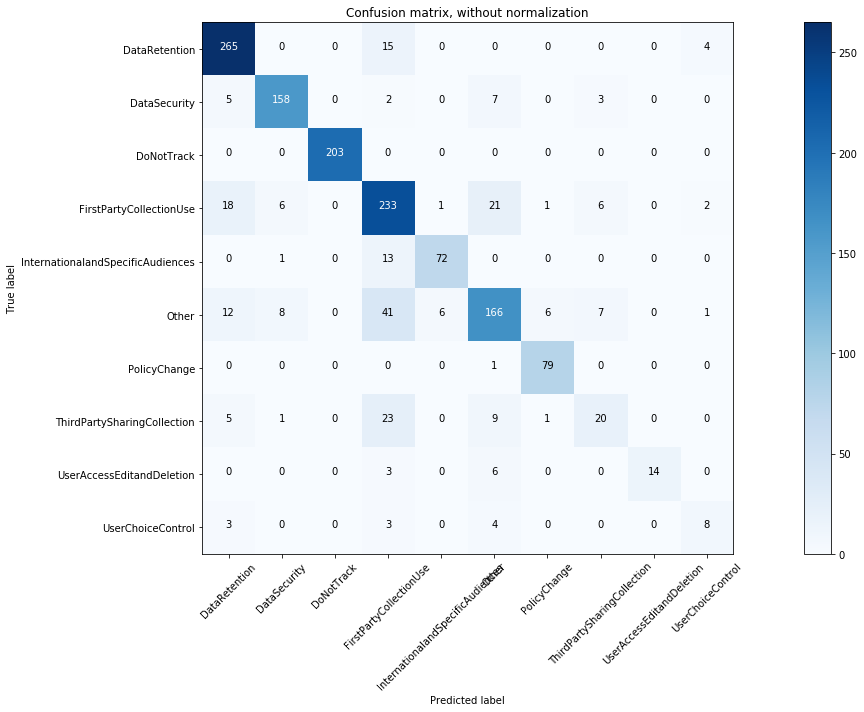

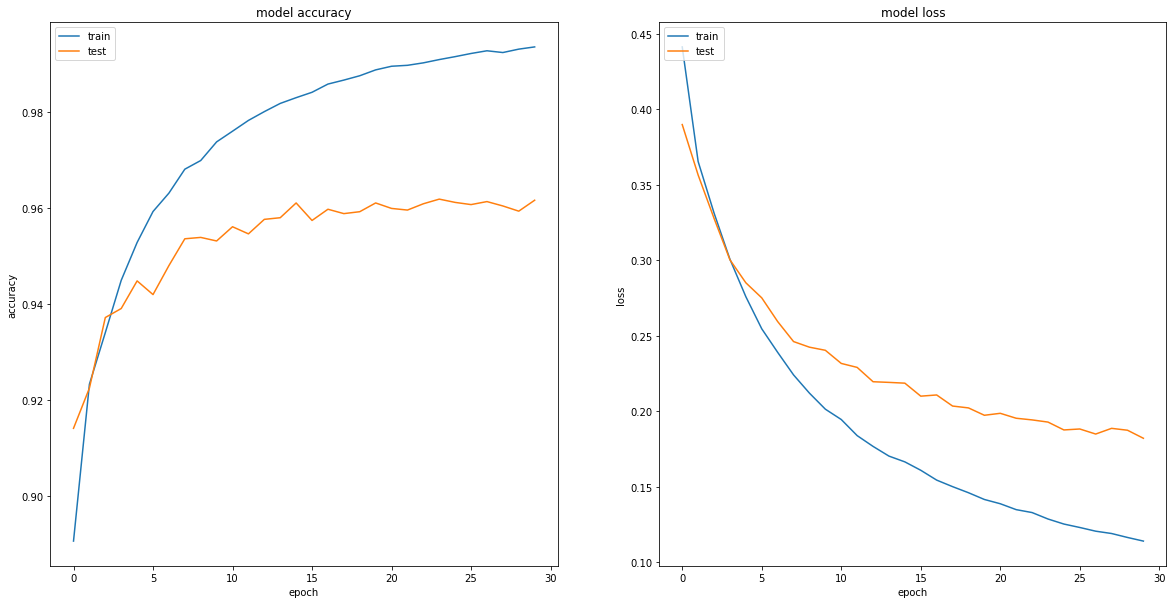

['use recommendation service email one articles friend need provide us friends email address email address return address automatically send person onetime email recommended article attached well invite friend visit register site use email addresses purpose']
[1 0 0 1 0 0 0 0 0 0]
[[6.75e-01 1.01e-03 6.45e-03 9.96e-01 1.37e-02 3.51e-02 2.87e-04 8.73e-02
  5.39e-03 4.50e-02]]


In [4]:
if __name__=="__main__": main()

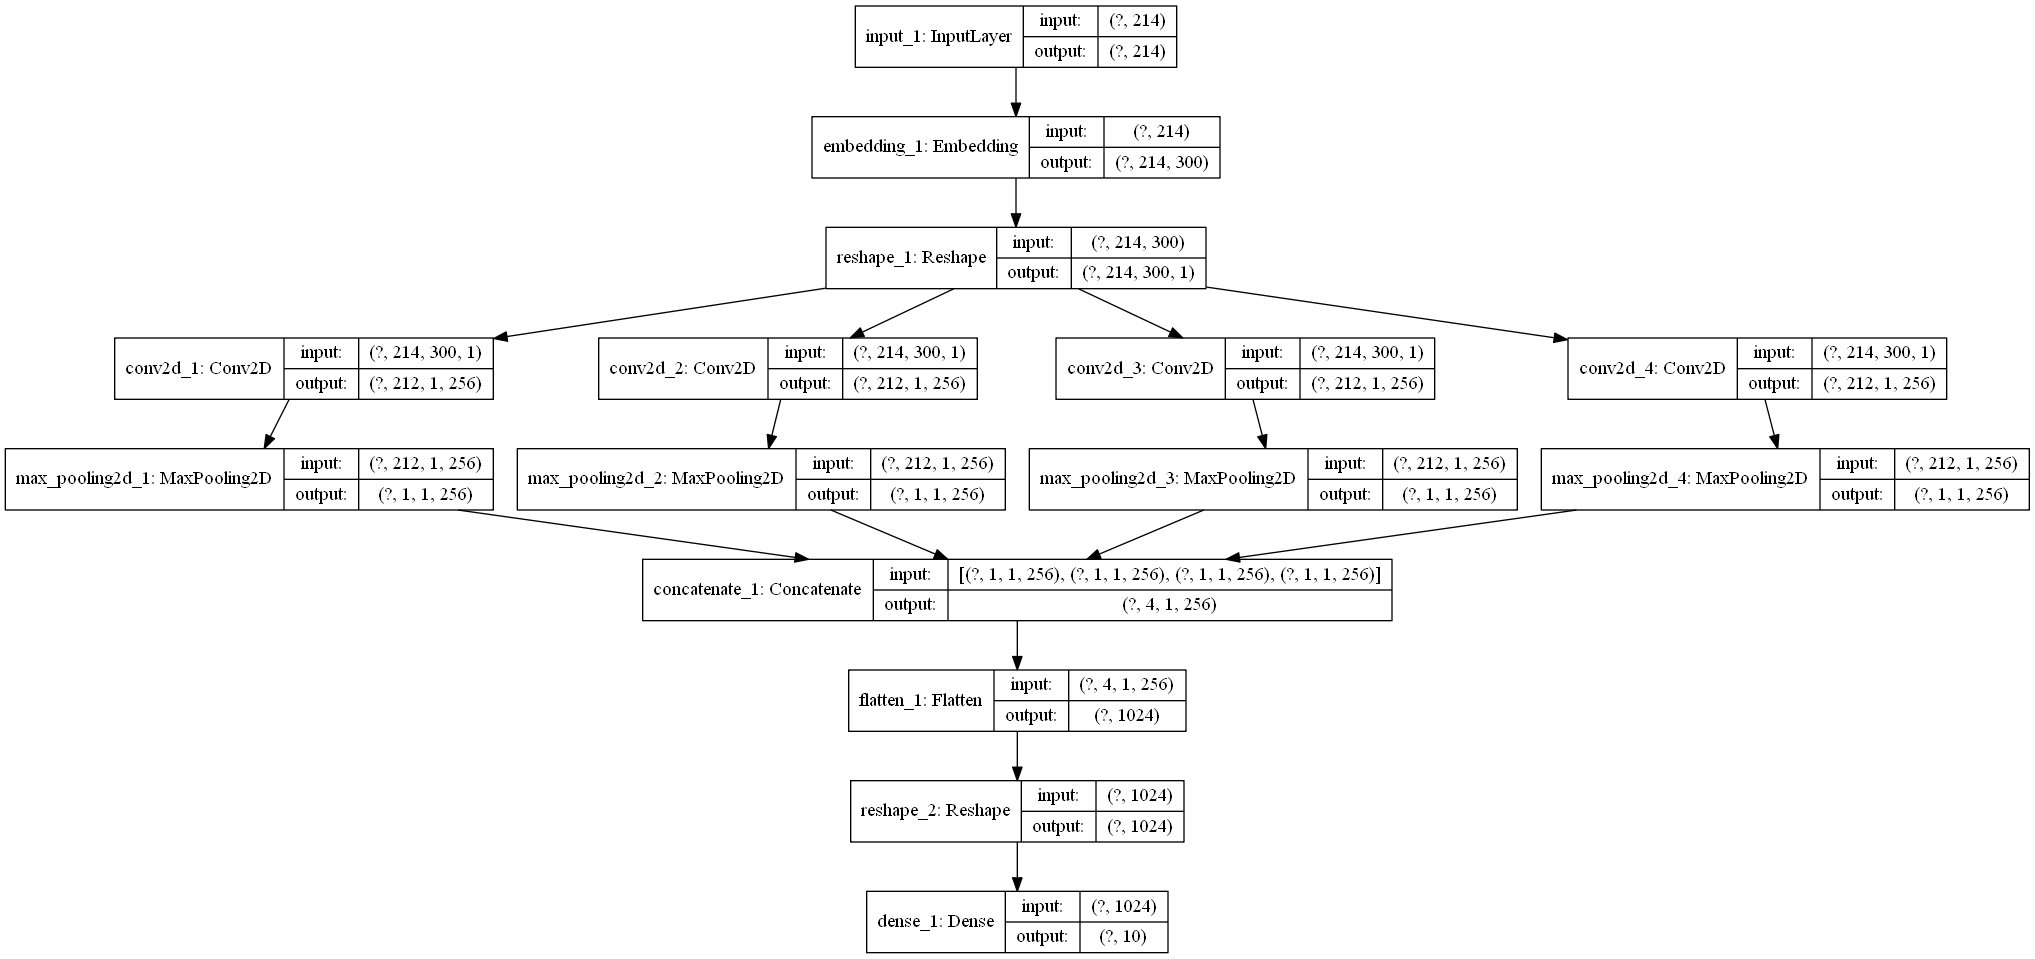

In [2]:
from keras.models import model_from_json
from tensorflow.keras.utils import plot_model
with open("../../models/BaseClassifier.json", "r") as f:
    data = f.read()
    model = model_from_json(data)
model.load_weights("base_classifier_weights.h5")
plot_model(model, to_file='base_model.png', show_shapes=True, show_layer_names=True)